<a href="https://colab.research.google.com/github/juooo1117/Artificial_Intelligence/blob/main/alexnet_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os # 파이썬을 이용해 파일을 복사하거나 디렉터리를 생성하고 특정 디렉터리 내의 파일 목록을 구하고자 할 때 사용
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision # torchvision package : 컴퓨터 비전을 위한 유명 데이터셋, 모델 아키텍처, 이미지 변형등을 포함
import torch.nn as nn # nn : neural netwroks (define class) attribute를 활용해 state를 저장하고 활용
import torch.optim as optim # 최적화 알고리즘
import torch.nn.functional as F # (define function) 인스턴스화 시킬 필요없이 사용 가능
from PIL import Image
from torchvision import transforms, datasets # transforms : 데이터를 조작하고 학습에 적합하게 만듦.
from torch.utils.data import Dataset, DataLoader

import sys
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

In [3]:
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)

TensorFlow version :  2.13.0
Keras version :  2.13.1


In [4]:
epochs = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(device)

cuda


In [5]:
transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor()])

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

validation_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11047306.44it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173285.84it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3264954.22it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8504244.58it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [6]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=227, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [7]:
validation_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=227, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

# **데이터로더 (DataLoader)Permalink**

데이터를 batch 단위로 모델에 넣어줌

전체 데이터 가운데 일부 인스턴스를 뽑아(sample) 배치를 구성한다.

In [8]:
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

In [9]:
print(training_loader.batch_size)
print(validation_loader.batch_size)

64
64


Shirt


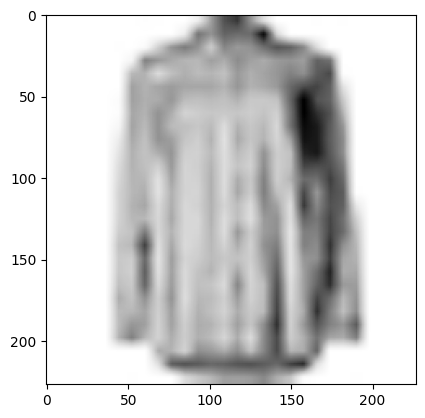

In [10]:
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")

# get some random training images
images, labels = next(iter(training_loader))

# create grid of images
img_grid = torchvision.utils.make_grid(images[0])

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

# **AlexNet 모델구현**

파이토치에서 제공하는 layer를 사용하여 모델 빌드를 간편하게 하기 위해서는

nn.Module을 상속받고, 이를 초기화 함으로써 nn.Module에서 상속받는 특성들을 초기화해주는 것이 필요하다.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class my_alexnet(nn.Module):
    def __init__(self, fashion_label=10):
        super(my_alexnet,self).__init__()

      # Convolution layer
        self.convolution = nn.Sequential(
            #CONV1
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),

            #CONV2
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),

            #CONV3
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            #CONV4
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            #CONV5
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )


     # Fully connected layer
        self.fully_connected = nn.Sequential(
            #FC1
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(),

            #FC2
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),

            #FC3 ( = output 10개의 fashion_label)
            nn.Linear(in_features=4096, out_features=fashion_label),
        )


    def forward(self, x):
        out = self.convolution(x)   # convolution layer 적용
        out = out.view(out.size(0), -1)
        out = self.fully_connected(out)  # fully connected layer 적용

        out = F.log_softmax(out, dim=1)  # 모두 합쳐서 1이 되도록 normalize

        return out

In [12]:
class fashion_mnist_alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            # 4D tensor : [number_of_kernels, input_channels, kernel_width, kernel_height]
            # = 96x1x11x11
            # input size : 1x227x227
            # input size 정의 : (N, C, H, W) or (C, H, W)
            # W' = (W-F+2P)/S + 1
            # 55x55x96 feature map 생성 (55는 (227-11+1)/4)
            # 최종적으로 227 -> 55
            nn.ReLU(), # 96x55x55
            nn.MaxPool2d(kernel_size=3, stride=2)
            # 55 -> (55-3+1)/2 = 26.5 = 27
            # 96x27x27 feature map 생성

        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2), # in_channels: 96, out_channels: 256, kernel_size=5x5, stride=1, padding=2
            # kernel 수 = 48x5x5 (드롭아웃을 사용했기 때문에 96/2=48) 형태의 256개
            # 256x27x27
            nn.ReLU(),
            nn.MaxPool2d(3, 2) # 27 -> 13
            # 256x13x13
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU() # 13 유지
            # 384x13x13
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU() # 13 유지
            # 384x13x13
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2) # 13 -> 6
            # 256x6x6
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x): # input size = 3x227x227
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out) # 64x4096x1x1
        out = out.view(out.size(0), -1) # 64x4096

        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)

        return out

In [13]:
model = fashion_mnist_alexnet().to(device)

criterion = F.nll_loss
optimizer = optim.Adam(model.parameters())

In [14]:
# get the model summary
from torchsummary import summary
summary(model, input_size=(1, 227, 227), batch_size=(512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [512, 96, 55, 55]          11,712
              ReLU-2          [512, 96, 55, 55]               0
         MaxPool2d-3          [512, 96, 27, 27]               0
            Conv2d-4         [512, 256, 27, 27]         614,656
              ReLU-5         [512, 256, 27, 27]               0
         MaxPool2d-6         [512, 256, 13, 13]               0
            Conv2d-7         [512, 384, 13, 13]         885,120
              ReLU-8         [512, 384, 13, 13]               0
            Conv2d-9         [512, 384, 13, 13]       1,327,488
             ReLU-10         [512, 384, 13, 13]               0
           Conv2d-11         [512, 256, 13, 13]         884,992
             ReLU-12         [512, 256, 13, 13]               0
        MaxPool2d-13           [512, 256, 6, 6]               0
           Linear-14                [51

# **train/test data 정의**

In [15]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [16]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  # -> mean
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)

In [17]:
for epoch in range(1, epochs+1):
    train(model, device, training_loader, optimizer, epoch)
    test(model, device, validation_loader)

Train Epoch:1 [1856/60000 (3%)]	Loss: 1.295359
Train Epoch:1 [3776/60000 (6%)]	Loss: 0.988595
Train Epoch:1 [5696/60000 (9%)]	Loss: 0.839602
Train Epoch:1 [7616/60000 (13%)]	Loss: 0.839296
Train Epoch:1 [9536/60000 (16%)]	Loss: 0.717556
Train Epoch:1 [11456/60000 (19%)]	Loss: 0.791267
Train Epoch:1 [13376/60000 (22%)]	Loss: 0.486481
Train Epoch:1 [15296/60000 (25%)]	Loss: 0.581685
Train Epoch:1 [17216/60000 (29%)]	Loss: 0.522989
Train Epoch:1 [19136/60000 (32%)]	Loss: 0.524876
Train Epoch:1 [21056/60000 (35%)]	Loss: 0.262690
Train Epoch:1 [22976/60000 (38%)]	Loss: 0.312685
Train Epoch:1 [24896/60000 (41%)]	Loss: 0.441465
Train Epoch:1 [26816/60000 (45%)]	Loss: 0.439115
Train Epoch:1 [28736/60000 (48%)]	Loss: 0.334717
Train Epoch:1 [30656/60000 (51%)]	Loss: 0.290875
Train Epoch:1 [32576/60000 (54%)]	Loss: 0.402364
Train Epoch:1 [34496/60000 (57%)]	Loss: 0.400181
Train Epoch:1 [36416/60000 (61%)]	Loss: 0.290692
Train Epoch:1 [38336/60000 (64%)]	Loss: 0.272816
Train Epoch:1 [40256/60000 (

In [1]:
import tensorflow as tf
from keras.preprocessing import image
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.models import load_model

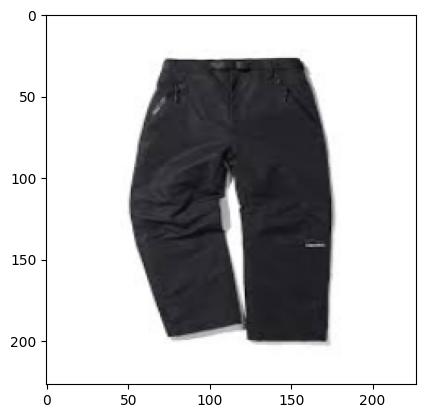

In [20]:
#이미지 불러오기
sample = image.load_img('/pants_trial.jpeg')

sample_vector = np.asarray(image.img_to_array(sample))
sample_vector = sample_vector/255

final_sample = resize(sample_vector, (227,227))
final_sample.shape
plt.imshow(final_sample)